# Anomaly Detection Exercises

In [2]:
from __future__ import division

import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest

import numpy as np
import pandas as pd
import collections
import math

from sklearn import metrics
from random import randint
from matplotlib import style

import seaborn as sns

style.use('fivethirtyeight')
%matplotlib inline

pd.set_option('display.max_rows', 50000)

In [3]:
def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

# Discrete data + probability

> Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

In [135]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']

df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [136]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
ip                13978 non-null object
timestamp         13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [138]:
df.timestamp = df.timestamp.str.replace('[', '')
df.timestamp = df.timestamp.str.replace(']', '')
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [139]:
df.tail()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-17 12:55:14,97.105.19.58,"""GET /api/v1/sales?page=71 HTTP/1.1""",200,510166,NaN,"""python-requests/2.21.0"""
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,1153005,NaN,python-requests/2.21.0
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales?page=79/HTTP/1.1,301,1005,NaN,python-requests/2.21.0
2019-04-18 19:42:41,97.105.15.120,GET /api/v1/sales?page=79/HTTP/1.1,301,2560,NaN,python-requests/2.21.0
2019-04-19 19:42:41,97.105.19.58,GET /api/v1/sales?page=79/HTTP/1.1,200,2056327,NaN,python-requests/2.21.0


In [140]:
df.request_method = df.request_method.str.replace('"', '')
df.request_agent = df.request_agent.str.replace('"', '')
df.destination = df.destination.str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [141]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [142]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


In [14]:
my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')

df_ts_size = df['size_mb'].resample('30T').median()

idx = pd.date_range(
    df_ts_size.sort_index().index.min(), 
    df_ts_size.sort_index().index.max(),
    freq='30min'
)

df_ts_size = df_ts_size.reindex(idx, fill_value=0).fillna(value=0)

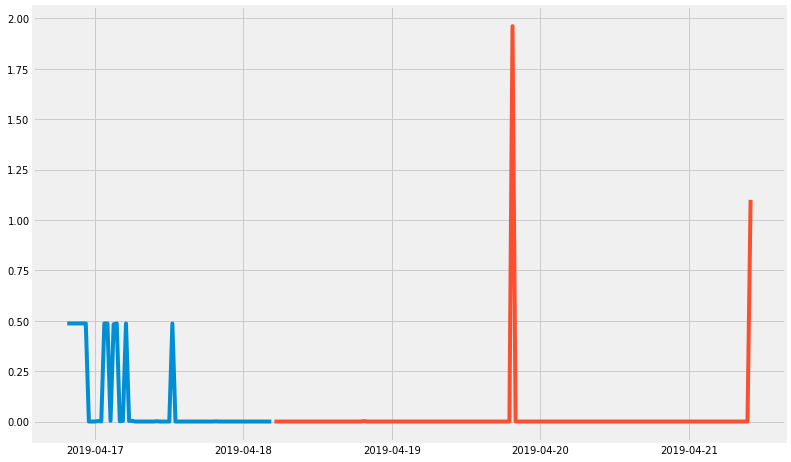

In [16]:
start_date_train = df_ts_size.head(1).index[0]
end_date_train = '2019-04-17 23:59:00'
start_date_test = '2019-04-18 00:00:00'

train = df_ts_size[:end_date_train]
test = df_ts_size[start_date_test:]

plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(test)
plt.show()

In [17]:
short_rolling = train.rolling(window=12).mean()
long_rolling = train.rolling(window=24).mean()

Text(0, 0.5, 'Size (MB)')

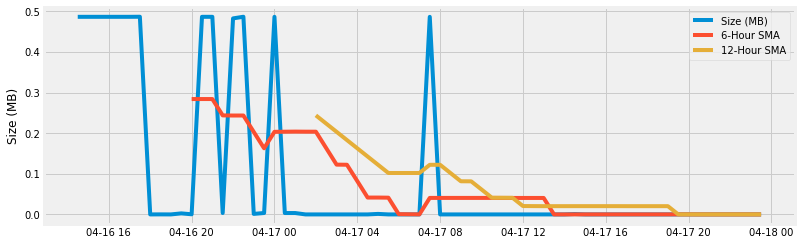

In [18]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

In [19]:
ema_short = train.ewm(span=12, adjust=False).mean()
ema_short[0:3]

ema_long = train.ewm(span=24, adjust=False).mean()
ema_long[0:3]

2019-04-16 14:30:00-05:00    0.486491
2019-04-16 15:00:00-05:00    0.486492
2019-04-16 15:30:00-05:00    0.486493
Freq: 30T, Name: size_mb, dtype: float64

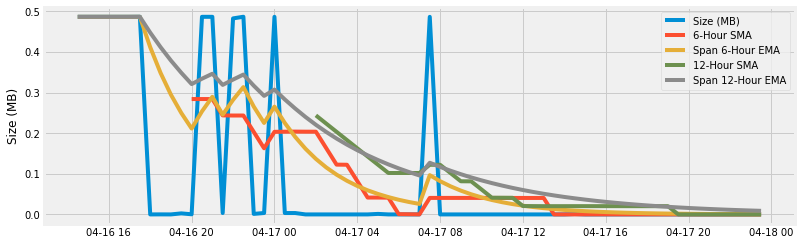

In [20]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 6-Hour EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 12-Hour EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

yhat = pd.DataFrame(dict(actual=test))

In [21]:
yhat['moving_avg_forecast'] = ema_long.iloc[-1]

In [22]:
### compute the absolute error:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

### compute upper band and lower band using IQR with weight of 3

q3 = yhat.error.describe().loc['75%']
q1 = yhat.error.describe().loc['25%']

### adding .1 to the IQR so the we don't end up with a denominator of 0. 
ub = q3 + 3*(q3-q1+.1)
lb = q1 - 3*(q3-q1+.1)

yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

In [24]:
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b
2019-04-19 14:30:00-05:00,1.961066,0.00884,1.952227,3.753711
2019-04-21 05:00:00-05:00,1.099591,0.00884,1.090752,2.317920


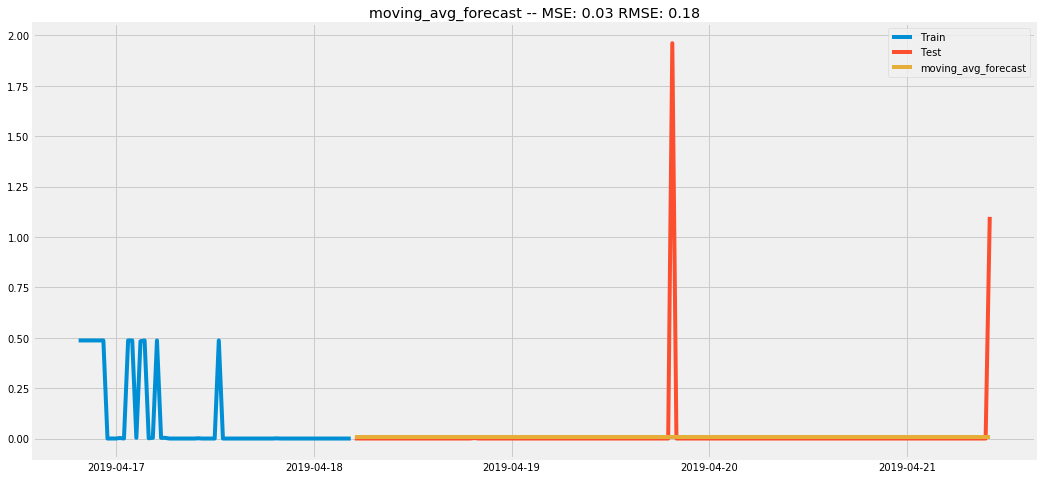

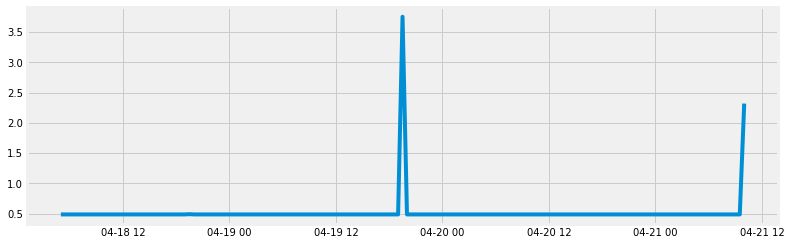

In [25]:
plot_and_eval(yhat.moving_avg_forecast, actual=test)
plt.figure(figsize=(12,4))
plt.plot(yhat.pct_b)

# Detecting Anomalies of Continuous Variables with Time Series Using Statistical Methods

> Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b. 

Bonus
> Can you label students who are viewing both the web dev and data science curriculum? Can you label students by the program they are in? Can you label users by student vs. staff? What is zach's id? What is maggie's id?

In [594]:
colnames=['date','page_viewed','user_id','cohort_id','ip']
df = pd.read_csv('anonymized-curriculum-access.txt',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0,2,3,4,5]
)

df = df.dropna()
df.cohort_id = df.cohort_id.astype('int')

In [595]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219070 entries, 0 to 233527
Data columns (total 5 columns):
date           219070 non-null object
page_viewed    219070 non-null object
user_id        219070 non-null int64
cohort_id      219070 non-null int64
ip             219070 non-null object
dtypes: int64(2), object(3)
memory usage: 10.0+ MB


In [596]:
colnames=['cohort_id','cohort_name','start_date','end_date']

In [597]:
df_cohort = pd.read_clipboard(sep=',',names=colnames, skiprows=1)

In [598]:
df = df.merge(df_cohort, on='cohort_id', how='left')
df = df[df.start_date >= '2018-01-26'].reset_index().drop(columns='index')

In [599]:
df['start_date'] = pd.to_datetime(df.start_date)
df['end_date'] = pd.to_datetime(df.end_date)
df['date'] = pd.to_datetime(df.date)
df.head()

,date,page_viewed,user_id,cohort_id,ip,cohort_name,start_date,end_date
0,2018-03-05,html-css/css-i,25,23,97.105.19.61,Ulysses,2018-03-05,2018-07-19
1,2018-03-05,html-css/forms,25,23,97.105.19.61,Ulysses,2018-03-05,2018-07-19
2,2018-03-05,html-css/css-i,25,23,97.105.19.61,Ulysses,2018-03-05,2018-07-19
3,2018-03-05,html-css/css-i/introduction,25,23,97.105.19.61,Ulysses,2018-03-05,2018-07-19
4,2018-03-05,html-css,25,23,97.105.19.61,Ulysses,2018-03-05,2018-07-19


In [600]:
df['days_normalized'] = (df['date']-df['start_date']).dt.days
df = df.groupby(['user_id','cohort_name','days_normalized', 'ip'])['page_viewed'].count().reset_index()

In [601]:
df.head()

,user_id,cohort_name,days_normalized,ip,page_viewed
0,25,Ulysses,0,97.105.19.61,15
1,25,Ulysses,1,97.105.19.61,9
2,25,Ulysses,2,97.105.19.61,56
3,25,Ulysses,3,97.105.19.61,11
4,25,Ulysses,4,70.120.83.9,10


In [602]:
OOP = df['days_normalized'] > 134
df = df[OOP]

In [603]:
df.describe()

,user_id,days_normalized,page_viewed
count,987.000000,987.000000,987.000000
mean,205.619048,200.163121,7.687943
std,67.051695,61.129619,10.173739
min,25.000000,135.000000,1.000000
25%,134.000000,148.000000,2.000000
50%,195.000000,180.000000,4.000000
75%,264.000000,240.000000,9.000000
max,371.000000,389.000000,153.000000


In [604]:
max_entries = df.groupby('cohort_name').max()

In [605]:
max_entries['longitude'] = [-98.4761, -95.3320, -98.6433, -96.7914, -95.3320]
max_entries['latitude'] = [29.3959, 29.6679, 29.4027, 32.9720, 29.6679]

In [606]:
max_entries

,user_id,days_normalized,ip,page_viewed,longitude,latitude
cohort_name,,,,,,
Ulysses,319,389,99.158.247.126,48,-98.4761,29.3959
Voyageurs,278,304,99.203.27.241,72,-95.3320,29.6679
Wrangell,282,248,99.52.75.127,153,-98.6433,29.4027
Xanadu,315,197,98.6.75.74,73,-96.7914,32.9720
Yosemite,371,148,99.203.27.223,36,-95.3320,29.6679


<Figure size 1152x1152 with 0 Axes>

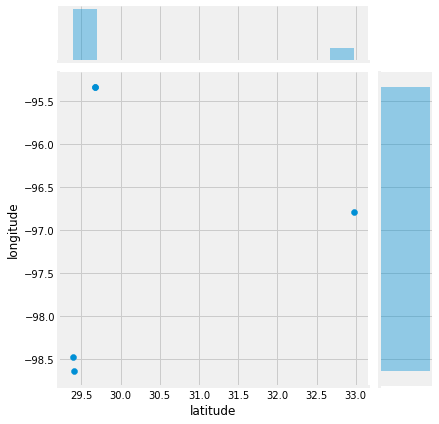

In [625]:
fig = plt.figure(figsize=(16,16))
sns.jointplot(x='latitude', y='longitude', data=max_entries)

# Clustering -DBSCAN  
> Use dbscan to detect anomalies in other products from the customers dataset.  


> Use dbscan to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [608]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [609]:
df = pd.read_csv('Wholesale customers data.csv')
df.columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

In [610]:
df = df[['Region', 'Fresh', 'Frozen']]

In [611]:
df.Region.value_counts()

3    316
1     77
2     47
Name: Region, dtype: int64

In [612]:
food_type = df[['Fresh', 'Frozen']]

In [613]:
np_array = food_type.values.astype('float32', copy=False)
np_array[0:5]

array([[12669.,   214.],
       [ 7057.,  1762.],
       [ 6353.,  2405.],
       [13265.,  6404.],
       [22615.,  3915.]], dtype=float32)

In [614]:
stscaler = StandardScaler().fit(np_array)
np_array = stscaler.transform(np_array)
np_array[0:5]

array([[ 0.05293319, -0.5893672 ],
       [-0.39130196, -0.27013618],
       [-0.44702926, -0.13753572],
       [ 0.1001114 ,  0.68714434],
       [ 0.8402394 ,  0.17385884]], dtype=float32)

In [620]:
dbsc = DBSCAN(eps = .75, min_samples = 20).fit(np_array)

In [621]:
labels = dbsc.labels_
labels[0:5]

array([0, 0, 0, 0, 0])

In [622]:
df['labels'] = labels
df.labels.value_counts()

 0    416
-1     24
Name: labels, dtype: int64

**Let's see where the anomalies land**

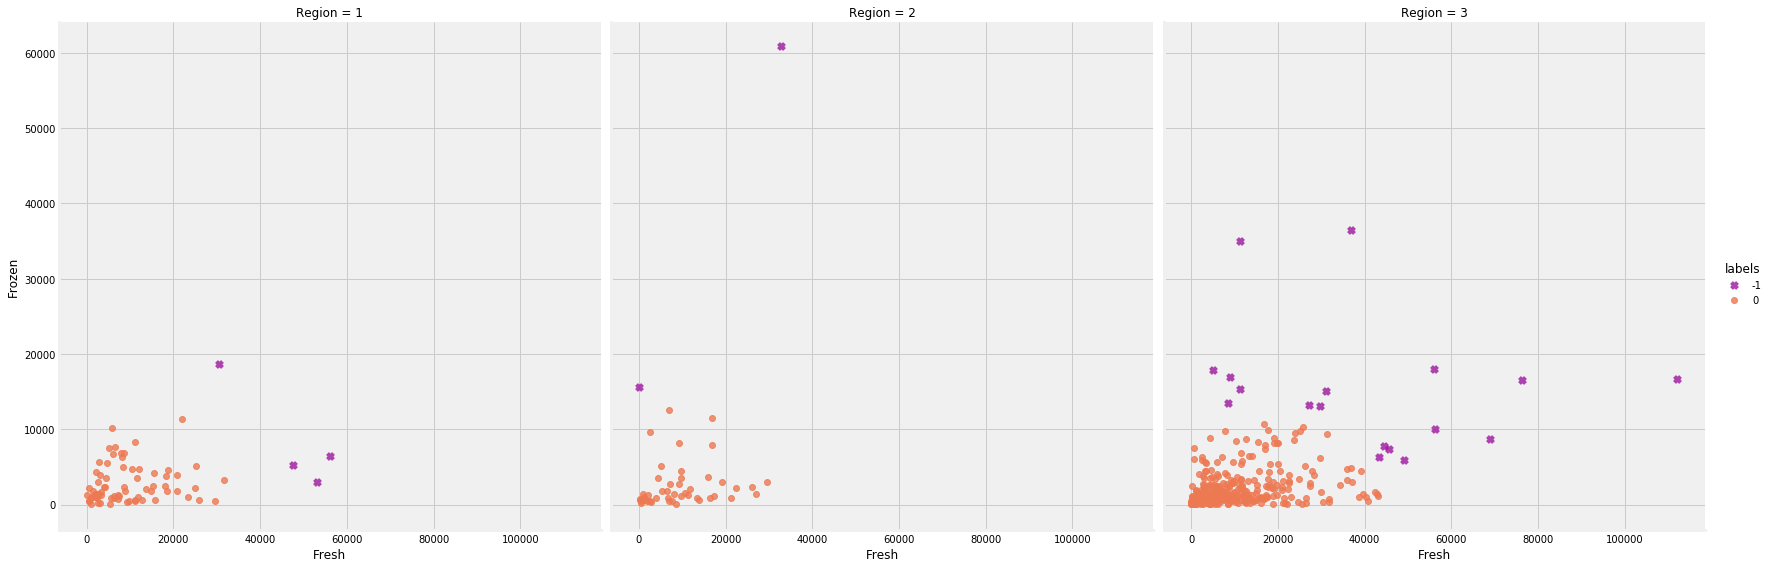

In [623]:
sns.lmplot(x='Fresh', y='Frozen', hue='labels', data=df, fit_reg=False, col='Region', markers=["x", "o"], height=8, palette='plasma')

**Anomalies per region**

In [624]:
df.groupby(df.Region).labels.value_counts()

Region  labels
1        0         73
        -1          4
2        0         45
        -1          2
3        0        298
        -1         18
Name: labels, dtype: int64